In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import qr_utils as qr
%matplotlib inline

In [3]:
def show(img, convert=False):
    if convert:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    plt.show()

In [4]:
qr_origin, qr_gray = qr.read_image(img_path='qr_projected.png', need_convert=True)

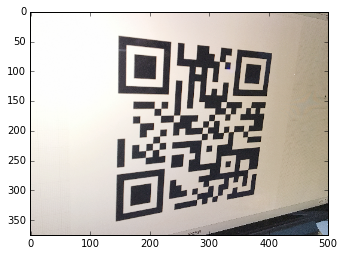

In [5]:
show(qr_origin)

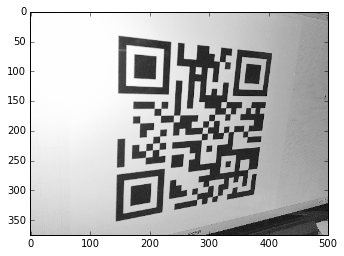

In [6]:
show(qr_gray)

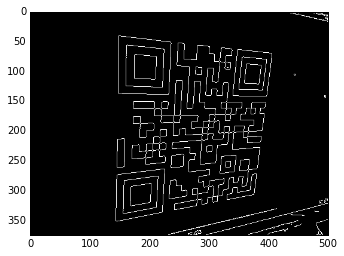

In [7]:
edges = qr.get_edges(qr_origin)
show(edges)

In [8]:
contours, hierarchy = qr.get_contours(edges)

In [9]:
found = qr.get_position_patterns(contours, hierarchy)

In [10]:
contours_points = qr.get_contours_points(found, contours)

In [11]:
box = qr.get_area_box(contours_points)

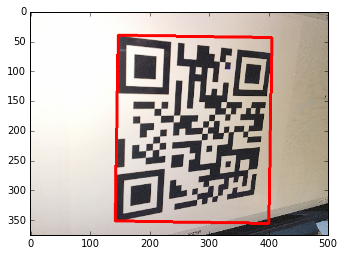

In [12]:
draw_img = qr_origin.copy()
cv2.polylines(draw_img, np.int32([box]), True, (255, 0, 0), 4)
show(draw_img)

In [13]:
boxes = qr.get_boxes(found, contours)

In [14]:
th, qr_bi = qr.get_binary_image(qr_gray)

In [15]:
boxes_dict, timing_patterns = qr.get_valid_boxes_index(boxes, qr_bi)

In [16]:
boxes_dict

{2: {0, 1, 2}}

In [17]:
qr_code_boxes = qr.get_qr_code_boxes(boxes_dict, contours, found)

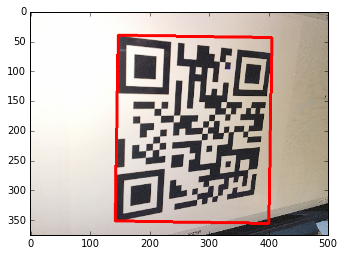

In [18]:
draw_img = qr_origin.copy()
cv2.polylines(draw_img, np.int32([qr_code_boxes.values()[0]]), True, (255, 0, 0), 4)
show(draw_img)

In [19]:
boxes

[[(143, 352), (143, 264), (225, 264), (225, 352)],
 [(396, 147), (337, 140), (346, 63), (404, 69)],
 [(232, 141), (143, 137), (148, 40), (236, 44)]]

In [20]:
qr_code_boxes.values()[0]

array([[ 399.80612183,  355.84613037],
       [ 142.66847229,  351.96484375],
       [ 147.36306763,   40.94512939],
       [ 404.50073242,   44.82641602]])

In [23]:
big_box_corners = qr_code_boxes.values()[0]

In [29]:
real_corners = []
base_distance = float('inf')
for i in range(len(big_box_corners)):
    for j in range(i+1, len(big_box_corners)):
        base_distance = min(base_distance, 
                            qr.__distance__(big_box_corners[i], big_box_corners[j]))
base_distance /= 2

for corner in big_box_corners:
    nearest_point = (base_distance, (0, 0))
    for box in boxes:
        for point in box:
            nearest_point = min([nearest_point, 
                                 (qr.__distance__(point, corner), point)],
                               key=lambda e: e[0])
    if nearest_point[0] < base_distance:
        real_corners.append(nearest_point[1])

In [30]:
real_corners

[(143, 352), (148, 40), (404, 69)]

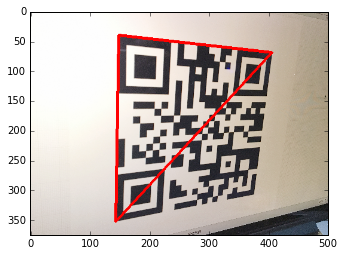

In [31]:
draw_img = qr_origin.copy()
cv2.polylines(draw_img, np.int32([real_corners]), True, (255, 0, 0), 4)
show(draw_img)

In [32]:
three_line_length = []
for i in range(len(real_corners)):
    for j in range(i+1, len(real_corners)):
        three_line_length.append(qr.__distance__(real_corners[i],
                                                real_corners[j]))

In [33]:
three_line_length

[312, 384, 257]

In [51]:
middle_length = sorted(three_line_length)[1]

In [39]:
real_corners = sorted(real_corners, key=lambda c: qr.__distance__((0,0), c))

In [42]:
real_corners

[(148, 40), (143, 352), (404, 69)]

In [43]:
real_corners[1:] = sorted(real_corners[1:], key=lambda c: c[0])[:]

In [44]:
real_corners

[(148, 40), (143, 352), (404, 69)]

In [45]:
src = np.float32(real_corners)

In [52]:
dst =np.float32([(10,10), (10+middle_length, 10), (10, 10+middle_length)])

In [53]:
M = cv2.getAffineTransform(src,dst)

In [56]:
out = cv2.warpAffine(qr_origin, M, (middle_length+20, middle_length+20))

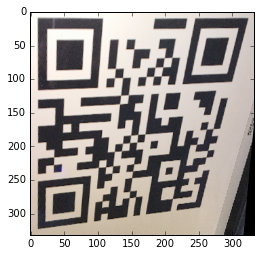

In [57]:
show(out)

## Use perspective transform